<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Music generation with an RNN

In this notebook we will learn how to generate music using a RNN.

Our training data will be a MIDI sequence of [the Goldberg Variations of J.S. Bach](http://www.jsbach.net/midi/midi_goldbergvariations.html). Given a sequence of notes from this data, we will train a model to predict the next note in the sequence. Longer sequences of notes can be generated by calling the model repeatedly.

 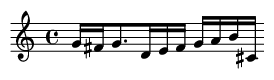

 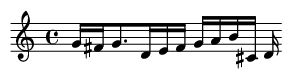

**Note**: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU. 

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/), you should install the dependencies by running the following cell:

In [1]:
! pip install numpy music21
! sudo apt-get install -qq timidity libsndfile1

### Import TensorFlow, Music21 and other libraries

[Music21](http://web.mit.edu/music21/doc/index.html) is a Python-based toolkit for computer-aided musicology.

In [2]:
import tensorflow as tf

import numpy as np
import os
import time

from music21 import *

# Configure ipython to listen WAV files
from IPython.display import Audio

### Download the J.S.Bach midi file (our training data)

In [3]:
path_to_file = tf.keras.utils.get_file('988-v01.mid', 'http://www.jsbach.net/midi/bwv988/988-v01.mid')

### Read the data

First, we will have a look in the midi stream:

In [4]:
# Read the MIDI file
mf = midi.MidiFile()
mf.open(path_to_file)
mf.read()
mf.close()

# Convert midi data into a stream of notes
stream = midi.translate.midiFileToStream(mf)

# We can also create a list of note names as follows
notes = [note.name for note in stream[0].notes]
print('Length of midi stream: {} notes'.format(len(notes)))


Length of midi stream: 596 notes


A file with the .MID or .MIDI file extension is a Musical Instrument Digital Interface file. 

Unlike regular audio files like MP3s or WAVs, these don't contain actual audio data and are therefore much smaller in size. They instead explain what notes are played, when they're played, and how long or loud each note should be. 

When we read a MIDI file with the <code>music21</code> library we get a stream (a list) of notes in ABC notation. ABC notation is a shorthand form of musical notation. In basic form it uses the letters A through G to represent notes in the following way: 

'C' -> do, 'D' -> re, 'E' -> mi, 'F' -> fa, 'G' -> sol, 'A' -> la, 'B' -> si.

In [5]:
# Take a look at the first 10 note names in our training data stream
print(notes[:10])

['G', 'F#', 'G', 'D', 'E', 'F#', 'G', 'A', 'B', 'C#']


In [6]:
# List all the unique note names in the stream
vocab_notes = sorted(set(notes))
print('{} unique notes'.format(len(vocab_notes)))
print(vocab_notes)

11 unique notes
['A', 'B', 'C', 'C#', 'D', 'E', 'E-', 'F', 'F#', 'G', 'G#']


But musical notes have also a duration, this information is stored in the data we read as follows:

In [7]:
# Take a look at the first 10 notes' duration in our training data stream
durations = [note.duration.quarterLength for note in stream[0].notes]

print(durations[:10])

[0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [8]:
# List the unique notes' durations in the stream
vocab_durations = sorted(set(durations))
print('{} unique durations'.format(len(vocab_durations)))
print(vocab_durations)

5 unique durations
[0.25, 0.5, 0.75, 1.0, 2.25]


Ideally we would like to have a model with two outputs at each time step: one for the note and the other for its duration. 

Here we will simplify this by considering the input/output elements of our RNN model to be a combination of a `note_name` and a `duration`.

In [9]:
# The complete training data sequence is a list of notes (and their durations)
notes = [n.name+' '+str(n.duration.quarterLength) for n in stream[0].notes]*10 # repeat 10 times

# The unique notes (and durations) in the stream
vocab = sorted(set(notes))
print('{} unique notes'.format(len(vocab)))
print(vocab)

26 unique notes
['A 0.25', 'A 0.5', 'A 0.75', 'B 0.25', 'B 0.5', 'B 2.25', 'C 0.25', 'C 0.5', 'C 1.0', 'C# 0.25', 'D 0.25', 'D 0.5', 'D 0.75', 'D 1.0', 'E 0.25', 'E 0.5', 'E 0.75', 'E- 0.25', 'F 0.25', 'F# 0.25', 'F# 0.5', 'G 0.25', 'G 0.5', 'G 0.75', 'G 1.0', 'G# 0.25']


At every time step our model will predict one of those 26 unique notes using a one-hot vector representation as in a classification problem.

## Process the music stream

### Vectorize the notes

Before training, you need to map notes (and durations) to a numerical representation. Create lookup tables mapping notes (and durations) to numbers, and numbers to notes (and durations).

In [10]:
# Creating a mapping from unique notes to indices
note2idx = {u:i for i, u in enumerate(vocab)}
idx2note = np.array(vocab)

note_stream_as_int = np.array([note2idx[n] for n in notes])

Now you have an integer representation (class label) for each note (and duration). Notice that you mapped the notes as indexes from 0 to `len(unique)`.

In [11]:
print('{')
for note,_ in zip(note2idx, range(11)):
    print('  {:4s}: class {:3d},'.format(repr(note), note2idx[note]))
print('  ...\n}')

{
  'A 0.25': class   0,
  'A 0.5': class   1,
  'A 0.75': class   2,
  'B 0.25': class   3,
  'B 0.5': class   4,
  'B 2.25': class   5,
  'C 0.25': class   6,
  'C 0.5': class   7,
  'C 1.0': class   8,
  'C# 0.25': class   9,
  'D 0.25': class  10,
  ...
}


In [12]:
# Show how the first 5 notes from the J.S.Bach MIDI stream are mapped to integers
print('{} ---- notes mapped to int ---- > {}'.format(repr(notes[:5]), note_stream_as_int[:5]))

['G 0.25', 'F# 0.25', 'G 0.75', 'D 0.25', 'E 0.25'] ---- notes mapped to int ---- > [21 19 23 10 14]


### Define the prediction task

Given a note, or a sequence of notes, what is the most probable next note? This is the task we're training the model to perform. The input to the model will be a sequence of notes, and we will train the model to predict the output—the following note at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the notes computed until this moment, what is the next note?


### Create training examples and targets

Next divide the notes' stream into example sequences. Each input sequence will contain `seq_length` notes from the stream.

For each input sequence, the corresponding targets contain the same length of stream, except shifted one note to the right.

So break the stream into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our stream is ['G', 'F#', 'G', 'D', 'E']. The input and output per time step would be as follow:

 - t=0: input='G', output='F#'
 - t=1: input='F#', output='G' 
 - t=2: input='G', ouput='D' 
 - t=3: input='D', ouput='E' 

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the notes vector into a stream of notes' indices.

In [13]:
# The maximum length sentence you want for a single input in notes
seq_length = 10
examples_per_epoch = len(notes)//(seq_length+1)

# Create training examples / targets
note_dataset = tf.data.Dataset.from_tensor_slices(note_stream_as_int)

for i in note_dataset.take(5):
    print(idx2note[i.numpy()])

G 0.25
F# 0.25
G 0.75
D 0.25
E 0.25


The `batch` method lets us easily convert these individual notes to sequences of the desired size.

In [14]:
sequences = note_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(' '.join(idx2note[item.numpy()])))

'G 0.25 F# 0.25 G 0.75 D 0.25 E 0.25 F# 0.25 G 0.25 A 0.25 B 0.25 C# 0.25 D 0.25'
'C# 0.25 D 0.75 A 0.25 B 0.25 C# 0.25 D 0.25 E 0.25 F# 0.25 D 0.25 G 0.25 F# 0.25'
'G 0.75 F# 0.25 E 0.25 D 0.25 C# 0.25 E 0.25 A 0.25 G 0.25 F# 0.25 E 0.25 D 0.25'
'C# 0.25 D 0.25 F# 0.25 A 0.25 G 0.25 F# 0.25 A 0.25 D 0.5 D 0.25 C 0.25 D 0.5'
'G 0.5 B 0.5 D 0.5 E 0.25 D 0.25 E 0.5 A 0.5 C 0.5 E 0.5 F# 0.25 E 0.25'


For each sequence, duplicate and shift it to form the input and target notes by using the `map` method to apply a simple function to each batch:

In [15]:
def split_input_target(chunk):
    input_notes = chunk[:-1]
    target_notes = chunk[1:]
    return input_notes, target_notes

dataset = sequences.map(split_input_target)

Print the first example input and target values:

In [16]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(' '.join(idx2note[input_example.numpy()])))
    print('Target data:', repr(' '.join(idx2note[target_example.numpy()])))

Input data:  'G 0.25 F# 0.25 G 0.75 D 0.25 E 0.25 F# 0.25 G 0.25 A 0.25 B 0.25 C# 0.25'
Target data: 'F# 0.25 G 0.75 D 0.25 E 0.25 F# 0.25 G 0.25 A 0.25 B 0.25 C# 0.25 D 0.25'


Each index of these vectors is processed as a one time step. For the input at time step 0, the model receives the index for "G" and tries to predict the index for "F#" as the next note. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input note.

In [17]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2note[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2note[target_idx])))

Step    0
  input: 21 ('G 0.25')
  expected output: 19 ('F# 0.25')
Step    1
  input: 19 ('F# 0.25')
  expected output: 23 ('G 0.75')
Step    2
  input: 23 ('G 0.75')
  expected output: 10 ('D 0.25')
Step    3
  input: 10 ('D 0.25')
  expected output: 14 ('E 0.25')
Step    4
  input: 14 ('E 0.25')
  expected output: 19 ('F# 0.25')


### Create training batches

You used `tf.data` to split the notes stream into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [18]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((32, 10), (32, 10)), types: (tf.int64, tf.int64)>

## Build The Model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each note to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [19]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 512

In [20]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [21]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

For each note the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next note:


## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [22]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 10, 26) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `10` but the model can be run on inputs of any length:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 128)           3328      
_________________________________________________________________
gru (GRU)                    (32, None, 512)           986112    
_________________________________________________________________
dense (Dense)                (32, None, 26)            13338     
Total params: 1,002,778
Trainable params: 1,002,778
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual note indices. This distribution is defined by the logits over the notes vocabulary.

**Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.**

Try it for the first example in the batch:

In [24]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next note index:

In [25]:
sampled_indices

array([18, 22, 11, 11,  7, 11, 25, 17, 24, 12])

Decode these to see the notes predicted by this untrained model:

In [26]:
print("Input: \n", repr(" ".join([idx2note[n] for n in input_example_batch[0]])))
print()
print("Next Note Predictions: \n", repr(" ".join(idx2note[sampled_indices])))

Input: 
 'D 0.25 G 0.25 B 0.25 G 0.25 F# 0.25 E 0.25 A 0.25 E 0.25 C# 0.25 A 0.25'

Next Note Predictions: 
 'F 0.25 G 0.5 D 0.5 D 0.5 C 0.5 D 0.5 G# 0.25 E- 0.25 G 1.0 D 0.75'


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next note.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [27]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 10, 26)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       3.2580342


Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [28]:
model.compile(optimizer='adam', loss=loss)

### Configure the checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [29]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [30]:
history = model.fit(dataset, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
16/16 [==============================] - 1s 5ms/step - loss: 3.1955
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 2.8752
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 2.4122
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1504
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 1.9216
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 1.7450
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 1.5740
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 1.4173
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 1.2478
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 1.1135
Epoch 11/100
16/16 [==============================] - 0s 5ms/step - loss: 0.9735
Epoch 12/100
16/16 [==============================] - 0s 5ms/step - loss: 0.8529
Epoch 13/100
16/16 [=================

## Generate music

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, you need to rebuild the model and restore the weights from the checkpoint.


In [31]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_100'

In [32]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 128)            3328      
_________________________________________________________________
gru_1 (GRU)                  (1, None, 512)            986112    
_________________________________________________________________
dense_1 (Dense)              (1, None, 26)             13338     
Total params: 1,002,778
Trainable params: 1,002,778
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the music stream:

* Begin by choosing a start sequence of notes, initializing the RNN state and setting the number of notes to generate.

* Get the prediction distribution of the next note using the start stream and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted note. Use this predicted note as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead of only one note. After predicting the next note, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted notes.


In [34]:
def generate_music(model, start_seq):
    # Evaluation step (generating music using the learned model)

    # Number of notes to generate
    num_generate = 100

    # Converting our start string to numbers (vectorizing)
    input_eval = [note2idx[s] for s in start_seq]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty list to store our results
    music_generated = []

    # Low temperature results in more predictable music.
    # Higher temperature results in more surprising music.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the note returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted note as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        music_generated.append(idx2note[predicted_id])

    return (start_seq + music_generated)

In [35]:
generated_seq = generate_music(model, start_seq=['F# 0.25','G 0.75','D 0.25','E 0.25','F# 0.25','G 0.25'])
print(generated_seq)

['F# 0.25', 'G 0.75', 'D 0.25', 'E 0.25', 'F# 0.25', 'G 0.25', 'A 0.25', 'B 0.25', 'C# 0.25', 'D 0.25', 'C# 0.25', 'D 0.75', 'A 0.25', 'B 0.25', 'C# 0.25', 'D 0.25', 'E 0.25', 'F# 0.25', 'D 0.25', 'G 0.25', 'F# 0.25', 'G 0.75', 'F# 0.25', 'E 0.25', 'D 0.25', 'C# 0.25', 'E 0.25', 'A 0.25', 'G 0.25', 'F# 0.25', 'E 0.25', 'D 0.25', 'C# 0.25', 'D 0.25', 'F# 0.25', 'A 0.25', 'G 0.25', 'F# 0.25', 'G 0.25', 'F# 0.25', 'A 0.25', 'D 0.25', 'F# 0.25', 'G 0.25', 'E 0.25', 'D 0.25', 'C# 0.25', 'F# 0.25', 'D 0.25', 'C# 0.25', 'B 0.25', 'A 0.25', 'G 0.25', 'F# 0.25', 'E 0.25', 'D 1.0', 'G 0.25', 'F# 0.25', 'G 0.75', 'D 0.25', 'E 0.25', 'F# 0.25', 'G 0.25', 'A 0.25', 'B 0.25', 'C# 0.25', 'D 0.25', 'C# 0.25', 'D 0.75', 'A 0.25', 'B 0.25', 'C# 0.25', 'D 0.25', 'E 0.25', 'F# 0.25', 'D 0.25', 'G 0.25', 'F# 0.25', 'G 0.75', 'F# 0.25', 'E 0.25', 'D 0.25', 'C# 0.25', 'E 0.25', 'A 0.25', 'G 0.25', 'F# 0.25', 'E 0.25', 'D 0.25', 'C# 0.25', 'G 0.25', 'E 0.25', 'C# 0.25', 'A 0.25', 'C# 0.25', 'E 0.25', 'G 0.25'

To listen the generated music we will create a new midi stream and play it:

In [36]:
from music21 import stream,note
generated_stream = stream.Stream() 

for n in generated_seq:
    
    myNote = note.Note(n.split(' ')[0])
    myNote.duration.quarterLength = float(n.split(' ')[1])
    generated_stream.append(myNote)
    
    
# show a midi player so we can listen the generated data
generated_stream.show('midi')

# the previous command doesn't work in colab notebooks
# we must convert midi to WAV in order to listen it in colab
generated_stream.write('midi', fp='test_output.mid')
wav_from_midi = 'test_output.wav'
! timidity test_output.mid -Ow -o $wav_from_midi
Audio(wav_from_midi)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
# Alternatively, you can download the midi file and reproduce it locally with a media player
from google.colab import files
files.download('test_output.mid') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The easiest thing you can do to improve the results is to gather more training data (we are using a quite short sequence of only 600 notes for training) and/or to train it for longer (try `EPOCHS = 300`).

You can also experiment with different start sequences, try adding another RNN layer to improve the model's accuracy, change the embedding dimension and/or the RNN number of units, or adjust the temperature parameter to generate more or less random predictions.